very loosely based on https://keras.io/examples/vision/mnist_convnet/

In [ ]:
outdim=1

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
bx_train = np.expand_dims(x_train, -1)
bx_test = np.expand_dims(x_test, -1)
print("x_train shape:", bx_train.shape)
print(bx_train.shape[0], "train samples")
print(bx_test.shape[0], "test samples")


# convert class vectors to binary class matrices
by_train = keras.utils.to_categorical(y_train, num_classes)
by_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
classes=[6,9]
x_train=np.array(
    [xx for xx,yy in zip(bx_train,by_train) if
      np.any([yy[cc] for cc in classes])
    ])
y_train=np.array([yy for yy in by_train if np.any([yy[cc] for cc in classes])])
print(x_train.shape)
print(y_train.shape)

xa_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      not np.any([yy[cc] for cc in classes])
    ])
ya_test=np.array([yy for yy in by_test if not np.any([yy[cc] for cc in classes])])
print(xa_test.shape)
print(ya_test.shape)
xn_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      np.any([yy[cc] for cc in classes])
    ])
yn_test=np.array([yy for yy in by_test if np.any([yy[cc] for cc in classes])])
print(xn_test.shape)
print(yn_test.shape)



(11867, 28, 28, 1)
(11867, 10)
(8033, 28, 28, 1)
(8033, 10)
(1967, 28, 28, 1)
(1967, 10)


In [ ]:
def loss(outdim):
    if outdim==1:
        def lss(a,b):
            q=b
            return K.mean((q-1)**2)
        return lss
    def lss(a,b):
        q=b
        pd=[i for i in range(len(q.shape))]
        pd.remove(pd[-1])
        pd.insert(0,len(pd))
        #print(pd)
        q=K.permute_dimensions(q,tuple(pd))
        #exit()

        #print(q.shape)

        adl=None

        for i in range(outdim):
            for j in range(i+1,outdim):
              ac=K.abs(K.mean(((q[i]-1)*(q[j]-1))))
              if adl is None:
                  adl=ac
              else:
                  adl+=ac

        return adl
    return lss

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(16, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(4, kernel_size=(2, 2), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4,kernel_size=(1,1),activation="linear",padding="same",use_bias=False),
        layers.Flatten(),
        layers.Dense(outdim,use_bias=False)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          16384     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 4)           256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 4)           1

In [ ]:
batch_size = 128
epochs = 5

model.compile(loss=loss(outdim), optimizer="adam", metrics=[])

model.fit(x_train,
          np.ones_like(x_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Epoch 1/5
84/84 [==============================] - 13s 147ms/step - loss: 0.0287 - val_loss: 0.0015
Epoch 2/5
84/84 [==============================] - 12s 145ms/step - loss: 0.0011 - val_loss: 8.7800e-04
Epoch 3/5
84/84 [==============================] - 12s 143ms/step - loss: 8.0696e-04 - val_loss: 7.5432e-04
Epoch 4/5
84/84 [==============================] - 12s 144ms/step - loss: 6.6314e-04 - val_loss: 7.1291e-04
Epoch 5/5
84/84 [==============================] - 12s 144ms/step - loss: 6.1208e-04 - val_loss: 8.5526e-04


In [ ]:
pa=model.predict(xa_test)
pn=model.predict(xn_test)

In [ ]:
print(pa.shape)
print(pn.shape)

(8033, 1)
(1967, 1)


In [ ]:
da=np.abs(pa-1)
dn=np.abs(pn-1)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(8033,) (1967,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.02108245 0.019720005
abnorm 0.029934239 0.026531413


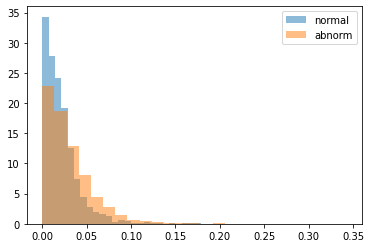

In [ ]:
import matplotlib.pyplot as plt

plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

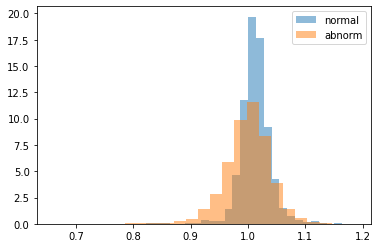

In [ ]:
plt.hist(pn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(pa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
def dexbyloss(lss):return np.argmin(np.abs(pn-lss))
minl=np.min(pn)
maxl=np.max(pn)
ls=np.arange(minl,maxl,(maxl-minl)/9.0001)
print(minl,ls,maxl)
print(len(ls))

0.8218532 [0.82185322 0.85993234 0.89801147 0.93609059 0.97416971 1.01224884
 1.05032796 1.08840708 1.12648621 1.16456533] 1.1645691
10


In [ ]:
dex=[dexbyloss(ll) for ll in ls]
print(dex)

[472, 1289, 1291, 582, 286, 1226, 578, 1262, 1411, 292]


In [ ]:
topl=np.array([xn_test[dd] for dd in dex])
print(topl.shape)


(10, 28, 28, 1)


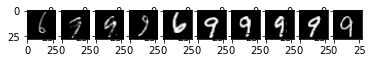

In [ ]:
for i,zw in enumerate(topl):
  plt.subplot(1,len(topl),i+1)
  plt.imshow(zw[:,:,0], cmap=plt.get_cmap('gray'))
plt.show()